In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
PATH = "/kaggle/input/digit-recognizer/"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [3]:
embedding_dims = 2
batch_size = 32
epochs = 5

In [4]:
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define class MNIST
I'll define `class MNIST` which was inherited `torch.utils.data.Dataset`.

In [5]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img
        

In [6]:
train_ds = MNIST(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

## Define TripletLoss

In [8]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Neural Network

In [9]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

### weight initialize

In [10]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

### Create Instances
Use JIT compilation for high speed.

In [11]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

## Training Loop

In [12]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))


Epoch: 1/5 - Loss: 0.2489


Epoch: 2/5 - Loss: 0.1172


Epoch: 3/5 - Loss: 0.0932


Epoch: 4/5 - Loss: 0.0776


Epoch: 5/5 - Loss: 0.0653



## Save Params

In [13]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

In [14]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

(42000, 2)

## Visualization 

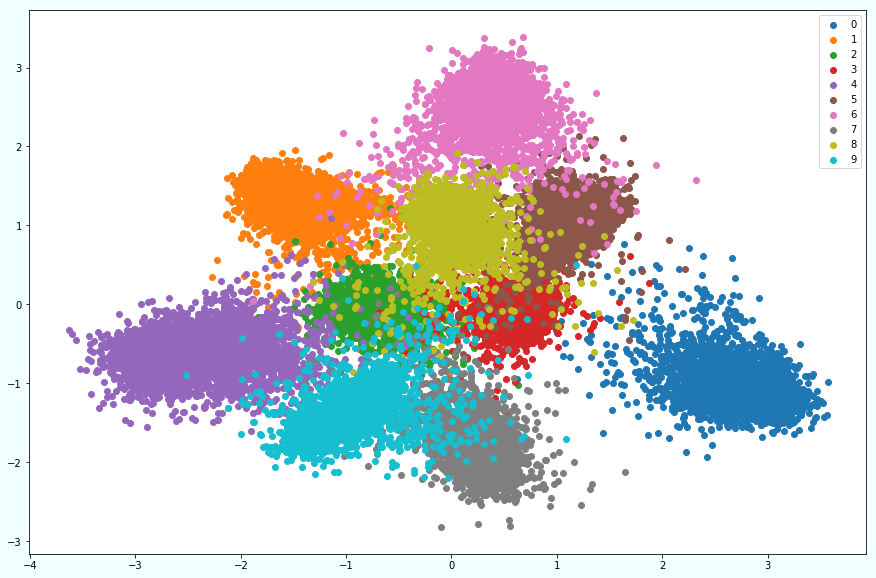

In [15]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

## Training XGBoost Model

In [16]:
tree = XGBClassifier(seed=2020)
tree.fit(train_results, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2020,
              silent=None, subsample=1, verbosity=1)

(28000, 2)

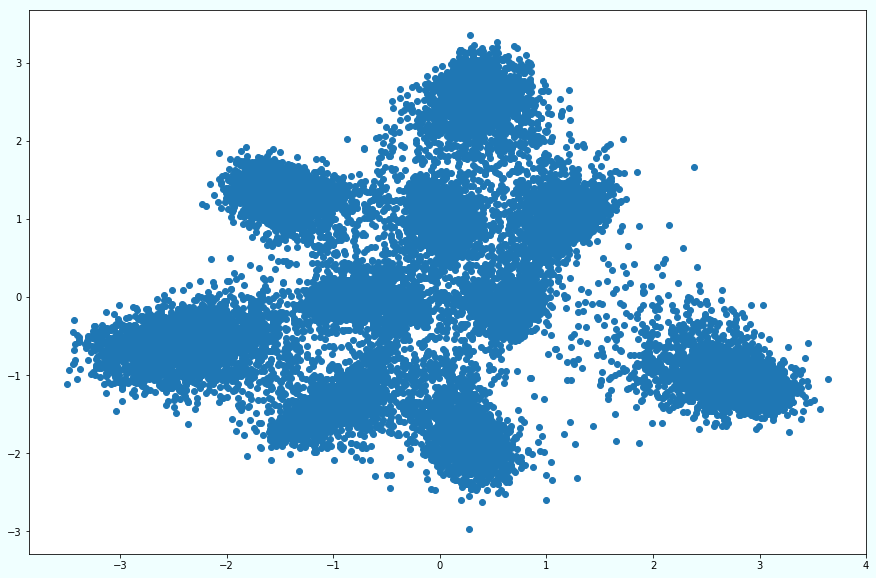

In [17]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for img in tqdm(test_loader):
        test_results.append(model(img.to(device)).cpu().numpy())
        
test_results = np.concatenate(test_results)

plt.figure(figsize=(15, 10), facecolor="azure")
plt.scatter(test_results[:, 0], test_results[:, 1], label=label)

test_results.shape

## Submit

In [18]:
submit = pd.read_csv(PATH+"sample_submission.csv")
submit.Label = tree.predict(test_results)

submit.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3


In [19]:
submit.to_csv("submission.csv", index=False)